In [46]:
import os
os.getcwd()

'/users/eleves-b/2023/thomas.gastellu/TDs/CSC_43M04_EP_challenge/flashy'

**Step 0 :** Set the execution directory to ensure this runs correctly

In [47]:
# os.chdir('/p/to/your/directory')

**Step 1 :** Load the meta data from the train_val.csv file with pandas. Run a quick print statement to check if the file was corectly parsed. 

In [48]:
import pandas as pd

df = pd.read_csv("../dataset/train_val.csv")  # Has title, channel, views, etc.

# Print info about the dataframe
print(f"DataFrame shape: {df.shape}")
print(f"Columns: {list(df.columns)}\n")

# For each column, print its name and first 20 values
for column in df.columns:
    print(f"\n{'='*50}")
    print(f"Column: {column}")
    print(f"{'='*50}")
    
    # Handle different display formats based on data type
    if df[column].dtype == 'object':  # For string columns
        for i, value in enumerate(df[column].head(20)):
            print(f"{i+1}. {value}")
    else:  # For numeric columns
        print(df[column].head(20).to_string())
    
    print()


DataFrame shape: (15482, 8)
Columns: ['Unnamed: 0', 'id', 'channel', 'title', 'date', 'description', 'views', 'year']


Column: Unnamed: 0
0      0
1      1
2      2
3      6
4     10
5     12
6     13
7     14
8     15
9     16
10    17
11    18
12    19
13    21
14    23
15    24
16    25
17    27
18    28
19    29


Column: id
1. --2s6hjGrm4
2. --DnfroyKQ8
3. --aiU7VQKEw
4. -0SrlZAvSVM
5. -13Y2Pe7kFs
6. -1ElNi3aewU
7. -1FZlgerlnQ
8. -1enK4XQvow
9. -1hANFUO3yc
10. -1nkzRrnVfA
11. -2G5aWo41FI
12. -2GXUooP7RA
13. -2QKZNWHaiw
14. -2nyTzsnfrQ
15. -33JjmUgM2A
16. -37nwIsz2BM
17. -38KYLeEfHU
18. -4eq9OGlkYw
19. -5Yye_6--lk
20. -5cvOGIezgc


Column: channel
1. UC-1rx8j9Ggp8mp4uD0ZdEIA
2. UC-1rx8j9Ggp8mp4uD0ZdEIA
3. UC-1rx8j9Ggp8mp4uD0ZdEIA
4. UCW6NyJ6oFLPTnx7iGRZXDDg
5. UC-1rx8j9Ggp8mp4uD0ZdEIA
6. UC-1rx8j9Ggp8mp4uD0ZdEIA
7. UCXLfJIEp91L-fD0gP131IaQ
8. UC-1rx8j9Ggp8mp4uD0ZdEIA
9. UC-1rx8j9Ggp8mp4uD0ZdEIA
10. UCW6NyJ6oFLPTnx7iGRZXDDg
11. UCrSvhrtUgpZT3EU0x1Zoy-w
12. UCrSvhrtUgpZT3EU0x1Zoy-w


**Step 2 :** Calculate topic embeddings using a sentence tranformer

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss

model = SentenceTransformer("all-MiniLM-L6-v2")

def make_text(row):
    return f"{row['title']} | {row['channel']} | {row['date']}"

texts = df.apply(make_text, axis=1).tolist()
topic_embeddings = model.encode(texts, convert_to_tensor=True, normalize_embeddings=True)
index = index = faiss.IndexFlatIP(topic_embeddings.shape[1])

**Step 3.1 :** Find the right number $k$ of neighbors to compute similarity score. We're going to do a similarity weighted sum of views to calculate the scores. FAISS index is used for efficient high dimensional k-NN search. 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

MAX_NEIGHBORS = 400
STEP = 5

In [51]:
from joblib import Parallel, delayed # Using joblib for parallel processing

average_similarity_scores = []
similarity_deviations = []
view_counts = df['views'].values

# Convert topic embeddings to numpy once
all_embeddings = topic_embeddings.cpu().numpy()

def process_single_embedding(i, neighbors_i, k, all_embeddings):
    """Process a single embedding and its neighbors"""
    sim = []
    current_embedding = all_embeddings[i]
    
    for j in range(k):
        neighbor_idx = neighbors_i[j+1]  # skip self
        neighbor_embedding = all_embeddings[neighbor_idx]
        # Compute cosine similarity (dot product since vectors are normalized)
        similarity = np.dot(current_embedding, neighbor_embedding)
        sim.append(similarity)
    
    return sim[k-1], np.std(sim)

for k in range(1, MAX_NEIGHBORS, STEP):
    print(f"Processing k={k}")
    _, neighbors = index.search(all_embeddings, k+1)
    
    # Parallel processing - will use all available cores
    results = Parallel(n_jobs=-1)(
        delayed(process_single_embedding)(i, neighbors[i], k, all_embeddings) 
        for i in range(len(all_embeddings))
    )
    
    # Unpack results
    similarities = [r[0] for r in results]
    deviations = [r[1] for r in results]
    
    # Calculate average similarity for this k value
    average_similarity_scores.append(np.mean(similarities))
    similarity_deviations.append(np.mean(deviations))

Processing k=1


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Processing k=6
Processing k=11
Processing k=16
Processing k=21
Processing k=26
Processing k=31
Processing k=36
Processing k=41
Processing k=46
Processing k=51
Processing k=56
Processing k=61
Processing k=66
Processing k=71
Processing k=76
Processing k=81
Processing k=86
Processing k=91
Processing k=96
Processing k=101
Processing k=106
Processing k=111
Processing k=116
Processing k=121
Processing k=126
Processing k=131
Processing k=136
Processing k=141
Processing k=146
Processing k=151
Processing k=156
Processing k=161
Processing k=166
Processing k=171
Processing k=176
Processing k=181
Processing k=186
Processing k=191
Processing k=196
Processing k=201
Processing k=206
Processing k=211
Processing k=216
Processing k=221
Processing k=226
Processing k=231
Processing k=236
Processing k=241
Processing k=246
Processing k=251
Processing k=256
Processing k=261
Processing k=266
Processing k=271
Processing k=276
Processing k=281
Processing k=286
Processing k=291
Processing k=296
Processing k=301


the multi-threading speed up is insane

15482


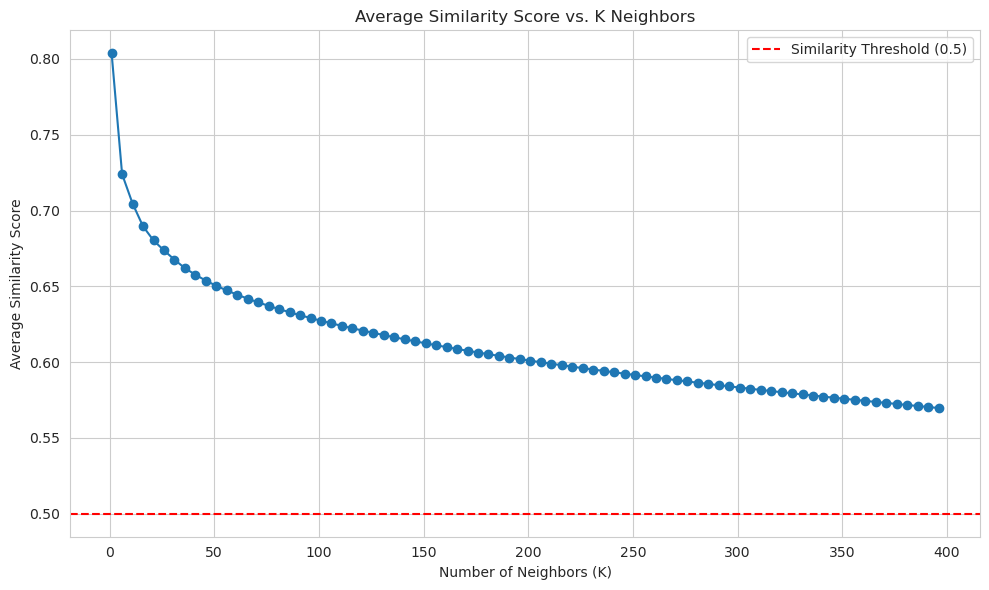

No handles with labels found to put in legend.


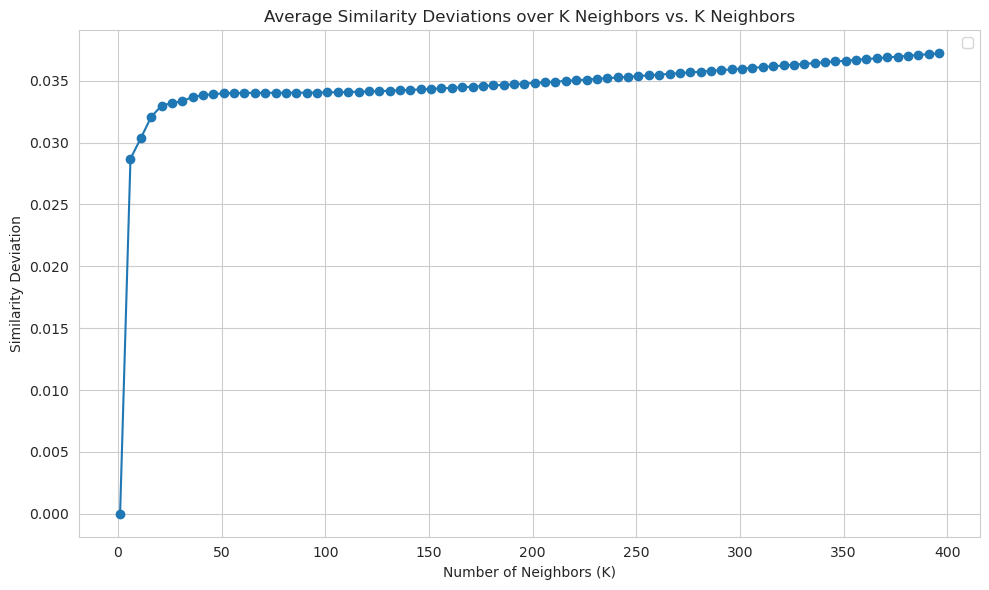

In [52]:
import matplotlib.pyplot as plt

print(len(view_counts))
# Plot the average similarity scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, MAX_NEIGHBORS, STEP), average_similarity_scores, marker='o')
plt.title('Average Similarity Score vs. K Neighbors')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Average Similarity Score')
plt.grid(True)
plt.axhline(y=0.5, color='r', linestyle='--', label='Similarity Threshold (0.5)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the similarity deviations
plt.figure(figsize=(10, 6))
plt.plot(range(1, MAX_NEIGHBORS, STEP), similarity_deviations, marker='o')
plt.title('Average Similarity Deviations over K Neighbors vs. K Neighbors')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Similarity Deviation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

No clear cut-off in average similarity, there for I'm going to wieght the views with the similarity score, and use k=100 (slight inflexion in similarity).

**Step 3.2 :** Calculate scores for the optimal number of neighbors $k$. 

In [53]:

k = 100  # number of neighbors
_, neighbors = index.search(topic_embeddings.cpu().numpy(), k+1)  # +1 to exclude self

view_counts = df['views'].values
flashiness = []


for i, n in enumerate(neighbors):
    
    neighbor_views = view_counts[n[1:]]  # skip self 
    '''
    First naive approach : 
    relative_view = view_counts[i] / (neighbor_views.mean() + 1e-6)
    score = np.log1p(relative_view)  # optional smoothing/log
    '''
    # Calculate similarity between current element and its neighbors
    sim = []
    current_embedding = topic_embeddings[i].cpu().numpy()
    for j in range(k):
        neighbor_idx = n[j+1]  # skip self
        neighbor_embedding = topic_embeddings[neighbor_idx].cpu().numpy()
        # Compute cosine similarity (dot product since vectors are normalized)
        similarity = np.dot(current_embedding, neighbor_embedding)
        sim.append(similarity)
    
    # normalize similarity
    sim = sim / np.sum(sim)
    weighted_sum = sum(sim[i] * neighbor_views[i] for i in range(k))
    score = np.log1p(view_counts[i]/weighted_sum)  # optional smoothing/log
    
    flashiness.append(score)

df["flashiness"] = flashiness
mean = df['flashiness'].mean()
std = df['flashiness'].std()
df['flashiness_z'] = (df['flashiness'] - mean) / std

**Step 4 :** Store results in a new csv, that has the falshiness score in an extra column

In [54]:
df.to_csv("../dataset/train_with_flashiness.csv", index=False)

**Step 5 :** Plot results (see if it seems somewhat coherent)

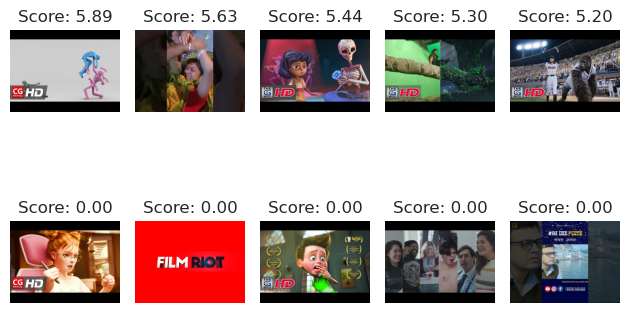

In [56]:
import matplotlib.pyplot as plt
import os
from PIL import Image

df = pd.read_csv("../dataset/train_with_flashiness.csv")
df_sorted = df.sort_values(by='flashiness', ascending=False)

# Number of examples to show from each end
n_examples = 5

plt.subplot(1, 2, 1)
plt.title("Highest Flashiness Scores", fontsize=16)
    
for i in range(min(n_examples, len(df_sorted))):
    row = df_sorted.iloc[i]
    img_path = os.path.join("../dataset/train_val", f"{row['id']}.jpg")
    
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.subplot(2, n_examples, i+1)
        plt.imshow(img)
        plt.title(f"Score: {row['flashiness']:.2f}")
        plt.axis('off')
    else:
        print(f"Image not found: {img_path}")

# Display examples with lowest flashiness scores
for i in range(min(n_examples, len(df_sorted))):
    row = df_sorted.iloc[len(df_sorted) - i - 1]
    img_path = os.path.join("../dataset/train_val", f"{row['id']}.jpg")
    
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.subplot(2, n_examples, n_examples + i + 1)
        plt.imshow(img)
        plt.title(f"Score: {row['flashiness']:.2f}")
        plt.axis('off')
    else:
        print(f"Image not found: {img_path}")

plt.tight_layout()
plt.show()

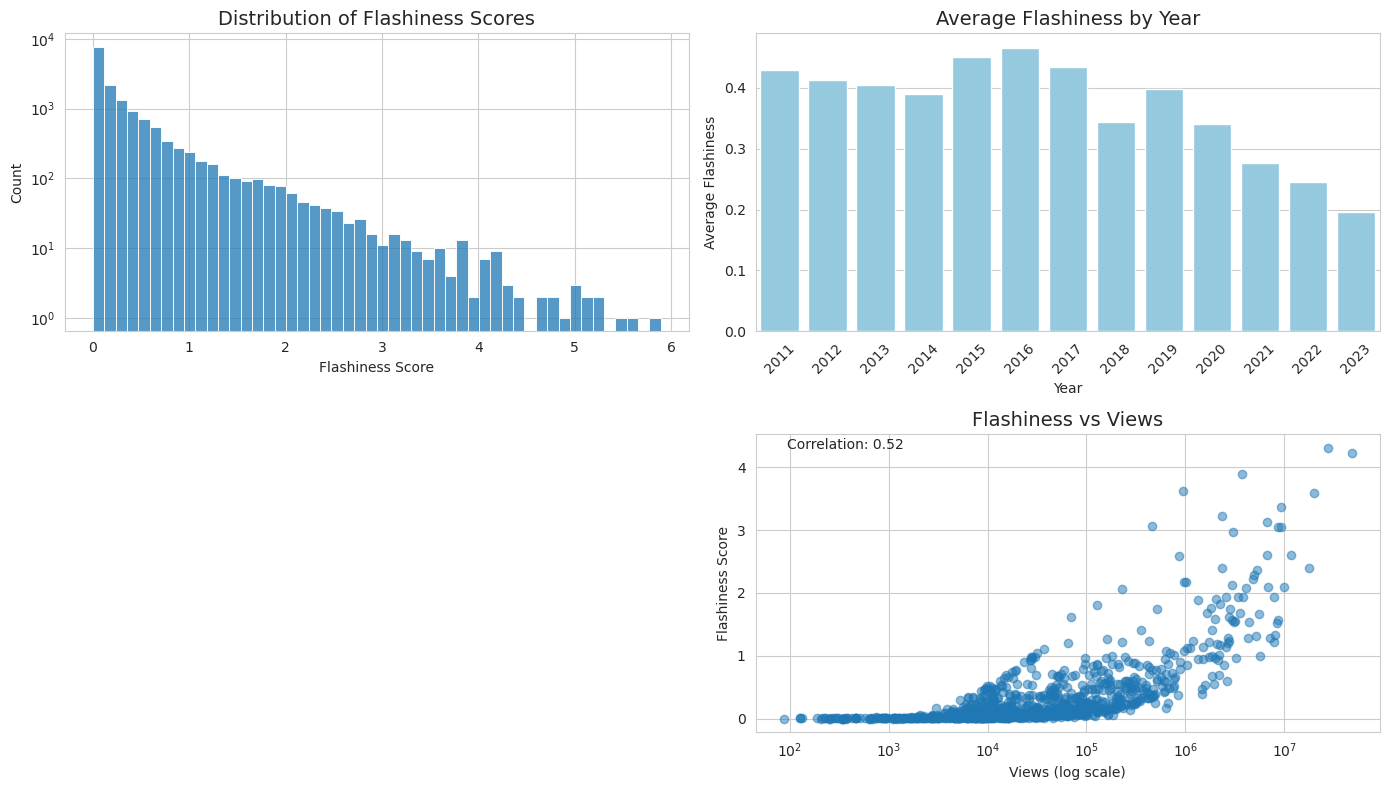

In [57]:
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(14, 8))


# Create subplot for overall distribution
plt.subplot(2, 2, 1)
sns.histplot(np.array(df['flashiness']), bins=50)
plt.title('Distribution of Flashiness Scores', fontsize=14)
plt.xlabel('Flashiness Score')
plt.ylabel('Count')
plt.yscale('log')  # Using log scale to better see the distribution

# Create subplot for flashiness by year
plt.subplot(2, 2, 2)
yearly_stats = df.groupby('year')['flashiness'].agg(['mean', 'median', 'std']).reset_index()
sns.barplot(x='year', y='mean', data=yearly_stats, color='skyblue')
plt.title('Average Flashiness by Year', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Average Flashiness')
plt.xticks(rotation=45)



# Create subplot for relation between views and flashiness
plt.subplot(2, 2, 4)
# Add small value to handle log scale
df_sample = df.sample(min(1000, len(df)))  # Sample to avoid overcrowding
plt.scatter(df_sample['views'], df_sample['flashiness'], alpha=0.5)
plt.xscale('log')
plt.title('Flashiness vs Views', fontsize=14)
plt.xlabel('Views (log scale)')
plt.ylabel('Flashiness Score')

# Compute correlation
corr = df['views'].corr(df['flashiness'])
plt.annotate(f'Correlation: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction')

plt.tight_layout()
plt.show()

Distribution almost log-linear. That's pretty much expected because most content is average, and there a just a few outliers that go viral. 